## PageRank

This is a translation of the [PageRank function](https://github.com/GraphBLAS/LAGraph/blob/master/Source/Algorithm/LAGraph_pagerank3a.c) for the GAP Benchmark work done by Dr. Tim Davis at TAMU.

"PageRank works by counting the number and quality of links to a page to determine a rough estimate of how important the website is. The underlying assumption is that more important websites are likely to receive more links from other websites." - <https://en.wikipedia.org/wiki/PageRank>

17


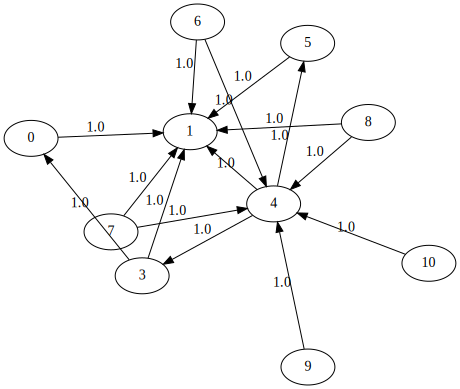

In [17]:
from operator import methodcaller
from pygraphblas import *
from pygraphblas.gviz import *
M = Matrix.sparse(FP32, 17, 17)


for i, j, v in [(int(i), int(j), float(v)) for (i, j, v) in list(map(methodcaller('split'), """1 2 1.0
2 1 1.0
4 1 1.0
4 2 1.0
5 2 1.0
5 4 1.0
5 6 1.0
6 2 1.0
6 5 1.0
7 2 1.0
7 5 1.0
8 2 1.0
8 5 1.0
9 2 1.0
9 5 1.0
10 5 1.0
11 5 1.0""".split('\n')))]:
    M[i-1, j-1] = v
print(len(list(M.cols)))

draw(M, graph_attr=dict(layout='neato'))

0|3.0
1|3.0
2|3.0
3|0.0213
4|0.0441
5|0.0213
6|0.00882
7|0.00882
8|0.00882
9|0.00882
10|0.00882
11|0.00882
12|0.00882
13|0.00882
14|0.00882
15|0.00882
16|0.00882


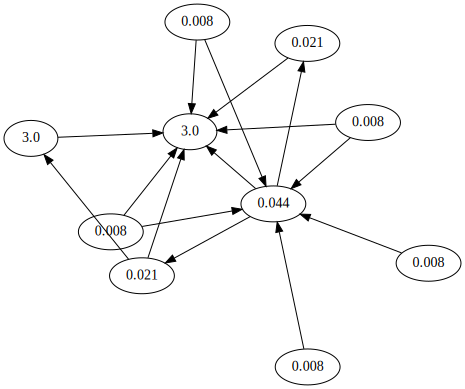

In [21]:
from pygraphblas import *
from pygraphblas.gviz import draw


def pagerank(A, d, damping, itermax):
    n = A.nrows
    r = Vector.sparse(FP32, n)
    t = Vector.sparse(FP32, n)
    d.assign_scalar(damping, accum=FP32.DIV)
    r[:] = 1.0 / n
    teleport = (1 - damping) / n
    tol = 1e-4
    rdiff = 1.0
    for i in range(itermax):
        # swap t and r
        temp = t ; t = r ; r = temp
        w = t / d
        r[:] = teleport
        A.mxv(w,
              out=r,
              accum=FP32.PLUS,
              semiring=FP32.PLUS_SECOND,
              desc=descriptor.T0)
        t -= r
        t.apply(FP32.ABS, out=t)
        rdiff = t.reduce_float()
        if rdiff <= tol:
            break
    return r

d = M.reduce_vector(FP32.PLUS_MONOID)
    
pr = pagerank(M, d, 0.85, 100)
pr.assign_scalar(3, [0, 1, 2])
print(pr)
draw(M, label_vector=pr, size_vector=pr, size_scale=2.0, show_weight=False, label_width=5, graph_attr=dict(layout='neato'))

# Another PageRank

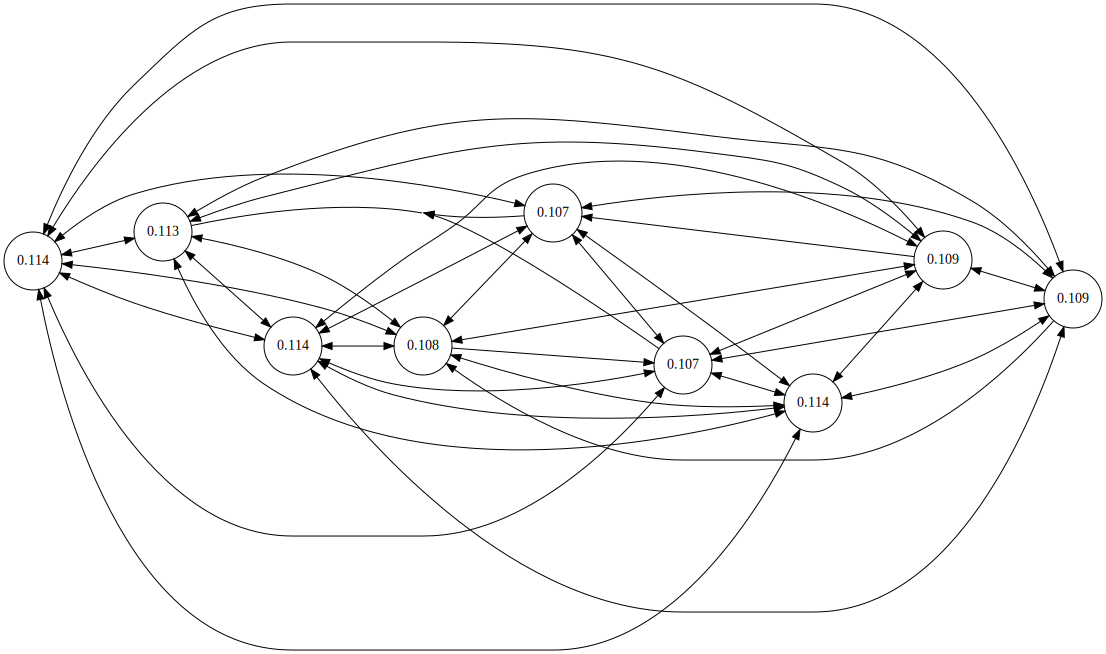

In [2]:

def pagerank2(A, damping_factor, itermax):
    n = A.nrows
    d_out = A.reduce_vector()
    pr = Vector.sparse(FP32, n)
    pr[:] = 1.0/n
    teleport = (1 - damping_factor) / n
    for i in range(itermax):
        importance_vec = pr / d_out
        with Accum(FP32.TIMES):
            importance_vec[:] = damping_factor
        importance_vec = A.transpose() @ importance_vec
        dangling_vec = pr[d_out]
        dangling_sum = dangling_vec.reduce_int() * (damping_factor / n)
        pr[:] = (teleport + dangling_sum)
        pr = pr + importance_vec
    return pr


pr = pagerank2(M, 0.35, 3)
draw(M, label_vector=pr, size_vector=pr, size_scale=7, show_weight=False, label_width=5)